<a href="https://colab.research.google.com/github/IhorKrain/CNN-Model-covid-19/blob/main/Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pranavraikokte/covid19-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\igork\.cache\kagglehub\datasets\pranavraikokte\covid19-image-dataset\versions\2


In [3]:
import os

for root, dirs, files in os.walk(path):
    print("Directory:", root)
    for file in files:
        print("  File:", file)

Directory: C:\Users\igork\.cache\kagglehub\datasets\pranavraikokte\covid19-image-dataset\versions\2
Directory: C:\Users\igork\.cache\kagglehub\datasets\pranavraikokte\covid19-image-dataset\versions\2\Covid19-dataset
Directory: C:\Users\igork\.cache\kagglehub\datasets\pranavraikokte\covid19-image-dataset\versions\2\Covid19-dataset\test
Directory: C:\Users\igork\.cache\kagglehub\datasets\pranavraikokte\covid19-image-dataset\versions\2\Covid19-dataset\test\Covid
  File: 0100.jpeg
  File: 0102.jpeg
  File: 0105.png
  File: 0106.jpeg
  File: 0108.jpeg
  File: 0111.jpg
  File: 0112.jpg
  File: 0113.jpg
  File: 0115.jpeg
  File: 0118.jpeg
  File: 0119.jpeg
  File: 0120.jpg
  File: 094.png
  File: 096.png
  File: 098.jpeg
  File: auntminnie-2020_01_31_20_24_2322_2020_01_31_x-ray_coronavirus_US.jpg
  File: auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
  File: auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
  File: auntminnie-c-2020_01_28_23_51_666

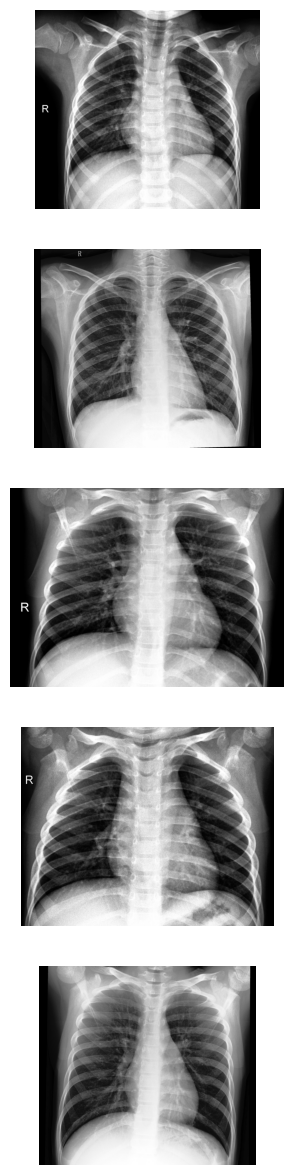

In [4]:
import os
import matplotlib.pyplot as plt

folder_path = 'C:/Users/igork/.cache/kagglehub/datasets/pranavraikokte/covid19-image-dataset/versions/2/Covid19-dataset/test/Normal'


files = [f for f in os.listdir(folder_path) if f.endswith(('.jpeg', '.jpg', '.png'))]

plt.figure(figsize=(25,15))
for i, file in enumerate(files[:5]):
    image_path = os.path.join(folder_path, file)
    image = plt.imread(image_path)
    plt.subplot(5,1, i+1)
    plt.imshow(image)
    plt.axis("off")

plt.show()

# **Train and test datasets**

In [5]:
import os
import pandas as pd

# data gathering function
def collect_image_data(base_path, label):
    data = []
    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith(('.jpeg', '.jpg', '.png')):
                image_path = os.path.join(root, file)
                data.append({'image_path': image_path, 'label': label})
    return data

base_path = 'C:/Users/igork/.cache/kagglehub/datasets/pranavraikokte/covid19-image-dataset/versions/2/Covid19-dataset'

train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

categories = ['Covid', 'Normal', 'Viral Pneumonia']

train_data = []
test_data = []

for category in categories:
    train_category_path = os.path.join(train_path, category)
    test_category_path = os.path.join(test_path, category)

    train_data += collect_image_data(train_category_path, category)
    test_data += collect_image_data(test_category_path, category)

train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

train_df.to_csv('train_dataset.csv', index=False)
test_df.to_csv('test_dataset.csv', index=False)

print("Train DataFrame:")
print(train_df.head())

print("\nTest DataFrame:")
print(test_df.head())


Train DataFrame:
                                          image_path  label
0  C:/Users/igork/.cache/kagglehub/datasets/prana...  Covid
1  C:/Users/igork/.cache/kagglehub/datasets/prana...  Covid
2  C:/Users/igork/.cache/kagglehub/datasets/prana...  Covid
3  C:/Users/igork/.cache/kagglehub/datasets/prana...  Covid
4  C:/Users/igork/.cache/kagglehub/datasets/prana...  Covid

Test DataFrame:
                                          image_path  label
0  C:/Users/igork/.cache/kagglehub/datasets/prana...  Covid
1  C:/Users/igork/.cache/kagglehub/datasets/prana...  Covid
2  C:/Users/igork/.cache/kagglehub/datasets/prana...  Covid
3  C:/Users/igork/.cache/kagglehub/datasets/prana...  Covid
4  C:/Users/igork/.cache/kagglehub/datasets/prana...  Covid


# Dataloader

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms
from PIL import Image

class ImageDataset(Dataset):
  def __init__(self,dataframe , transform = None):
    self.dataframe = dataframe
    self.transform = transform
    self.label_map = {'Covid':0 , 'Normal':1,'Viral Pneumonia':2}
  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self,idx):
    image_path = self.dataframe.iloc[idx,0]
    label = self.label_map[self.dataframe.iloc[idx,1]]
    image = Image.open(image_path).convert('RGB')
    if self.transform:
      image = self.transform(image)
    return image,label



In [7]:
transform  = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5] , std = [0.5,0.5,0.5]),])

train_dataset = ImageDataset(train_df , transform = transform)
test_dataset = ImageDataset(test_df , transform = transform)

train_loader = DataLoader(train_dataset , batch_size = 32 , shuffle = True)
test_loader = DataLoader(test_dataset , batch_size = 32 , shuffle = True)

torch.save(train_dataset, 'train_dataset.pth')
torch.save(test_dataset, 'test_dataset.pth')


# CNN model

In [8]:
class SimpleCNN(nn.Module):
  def __init__(self,num_classes):
    super(SimpleCNN,self).__init__()
    self.conv1 = nn.Conv2d(3,16,kernel_size=3,stride=1,padding=1)
    self.conv2 = nn.Conv2d(16,32,kernel_size = 3 , stride = 1,padding=1)
    self.fc1 = nn.Linear(32*32*32,128)
    self.fc2 = nn.Linear(128,num_classes)
    self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
    self.relu = nn.ReLU()

  def forward(self,x):
    x=self.pool(self.relu(self.conv1(x)))
    x=self.pool(self.relu(self.conv2(x)))
    x=x.view(x.size(0),-1)
    x = self.relu(self.fc1(x))
    x=self.fc2(x)
    return x

In [9]:
model = SimpleCNN(num_classes=3)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)

# Traning

In [11]:
num_epoch = 10
for epoch in range(num_epoch):
  model.train()
  train_loss = 0
  for images,labels in train_loader:
    images,labels = images.to(device),labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  print(f"Epoch {epoch+1}/{num_epoch}, Loss: {train_loss/len(train_loader):.4f}")


Epoch 1/10, Loss: 1.0143
Epoch 2/10, Loss: 0.3894
Epoch 3/10, Loss: 0.3115
Epoch 4/10, Loss: 0.2382
Epoch 5/10, Loss: 0.2019
Epoch 6/10, Loss: 0.1197
Epoch 7/10, Loss: 0.0969
Epoch 8/10, Loss: 0.0892
Epoch 9/10, Loss: 0.0485
Epoch 10/10, Loss: 0.0423


In [12]:
model.eval()
correct = 0
total = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
  for images,labels in test_loader:
    images,labels = images.to(device),labels.to(device)
    outputs = model(images)
    _,predicted = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 83.33%


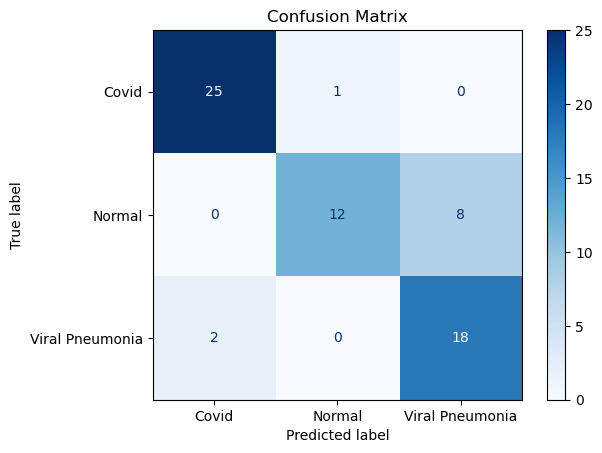

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

class_names = ['Covid', 'Normal', 'Viral Pneumonia']
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# One-vs-Rest (OvR)

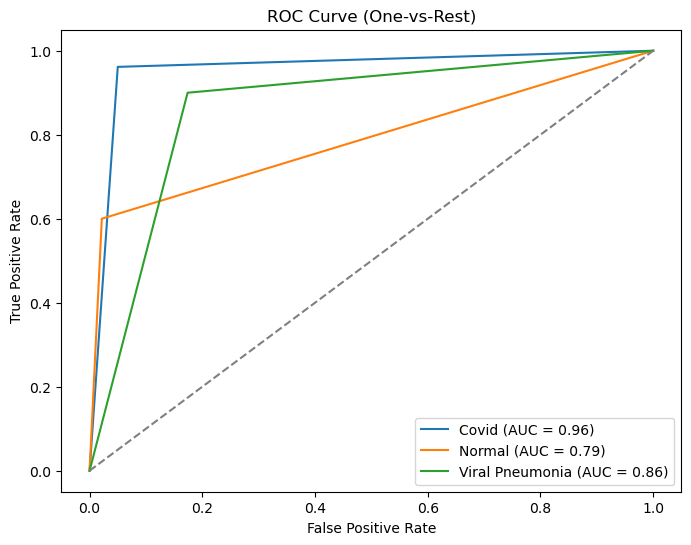

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


class_names = ['Covid', 'Normal', 'Viral Pneumonia']


y_true_bin = label_binarize(true_labels, classes=[0, 1, 2])
y_pred_bin = label_binarize(predicted_labels, classes=[0, 1, 2])

plt.figure(figsize=(8, 6))

for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend()
plt.show()



# Cohen's Kappa Score

In [20]:
from sklearn.metrics import cohen_kappa_score

kappa_1 = cohen_kappa_score(true_labels, predicted_labels)
print(f"Model 1 Cohen's Kappa: {kappa_1:.4f}")


Model 1 Cohen's Kappa: 0.7474


# Classification Report

In [21]:
from sklearn.metrics import classification_report

print("Model 1:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

Model 1:
                 precision    recall  f1-score   support

          Covid       0.93      0.96      0.94        26
         Normal       0.92      0.60      0.73        20
Viral Pneumonia       0.69      0.90      0.78        20

       accuracy                           0.83        66
      macro avg       0.85      0.82      0.82        66
   weighted avg       0.85      0.83      0.83        66



# Results

In [23]:
import pandas as pd
accuracy = [accuracy] * len(true_labels)
results = {
    'true_labels': true_labels,
    'predicted_labels': predicted_labels,
    'accuracy': accuracy
}

df = pd.DataFrame(results)
df.to_csv('results_my_model.csv', index=False)